In [1]:
%tensorflow_version 2.x

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [3]:
#Prediction of survival on the Titanic ship using linear regression using TensorFlow

#Load titanic dataset

#training data
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')

#testing data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

y_train = dftrain.pop('survived') #pop out/remove the 'survived' column in y_train
y_eval = dfeval.pop('survived') #pop out/remove the 'survived' column in y_eval

y_train.head()


0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [4]:
print(dftrain.loc[0], y_train.loc[0])

sex                          male
age                            22
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


In [5]:
#dftrain without 'survived' column
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
dftrain.shape

(627, 9)

627 entries, 9 features

In [8]:
y_train.head()  #0 - did not survive, 1 - survived

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

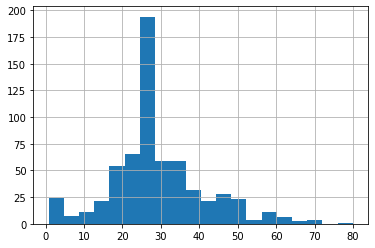

In [9]:
#Visualization of data

#Histogram of age
dftrain.age.hist(bins=20)

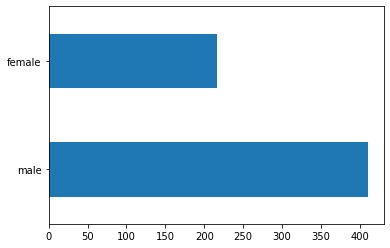

In [10]:
#Bar graph of sex
dftrain.sex.value_counts().plot(kind='barh')

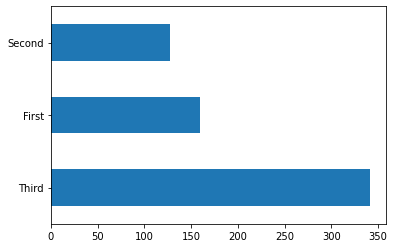

In [11]:
#Bar graph of class
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survival')

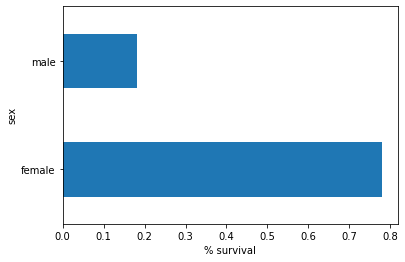

In [12]:
#Percentage survival by sex

pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survival')

Observations:
- Majority of passengers are in their 20's or 30's
- Majority of passengers are male
- Majority of passengers are in Third class
- Females have a much higher survival rate

In [13]:
#Training vs Testing

dfeval.shape #testing data is less than training data

(264, 9)

In [14]:
#Feature Columns
#We have Categorical(sex - male, female) and Numeric both type of data

#Convert Categorical data to numeric data

categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                       'deck', 'embark_town', 'alone']

numerical_columns = ['age', 'fare']

feature_columns = []

for feature_name in categorical_columns:
  vocab = dftrain[feature_name].unique() # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))

for feature_name in numerical_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)


[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [15]:
#Creating the model - Training process
#we will not feed entire dataset to the model at once
#batch size - 32 for the model, results in increase in speed
#epochs - 10

#input function
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function(): #inner function -> this will be returned

    #create tf.data.Dataset object with data and its labels
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))

    if shuffle:
      ds = ds.shuffle(1000) #make random order of data

    #split dataset into batches of 32 and repeat the process for number of epochs
    ds = ds.batch(batch_size).repeat(num_epochs)

    return ds #returns a batch of dataset

  return input_function #returns a function object for use

#call the input_function that was returned to get a dataset object we can feed to the model
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)




In [16]:
#Creating the model using linear regression

#create linear estimator and passing feature_columns created earlier
linear_reg = tf.estimator.LinearClassifier(feature_columns=feature_columns)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjwpaey7s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [19]:
#Training the model
linear_reg.train(train_input_fn) #train
result = linear_reg.evaluate(eval_input_fn) #get model metrics/stat by testing on testing data

clear_output() #clear console output
print(result['accuracy']) #the result variable is simply a dict of stats of model

0.7651515


In [20]:
print(result)

{'accuracy': 0.7651515, 'accuracy_baseline': 0.625, 'auc': 0.83749616, 'auc_precision_recall': 0.7829806, 'average_loss': 0.4707313, 'label/mean': 0.375, 'loss': 0.45936733, 'precision': 0.6831683, 'prediction/mean': 0.3828918, 'recall': 0.6969697, 'global_step': 400}


In [26]:
#Get predictions from model using predict function

r = list(linear_reg.predict(eval_input_fn))
print(r[0]['probabilities'][0]) 
print(r[0]['probabilities'][1]) 

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpjwpaey7s/model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.9451533
0.054846633


In [35]:
#1st person survival from dataset
print("\nFirst record of dataset\n",dfeval.loc[0])
print("\n",r[0]['probabilities'][1], "% chance of survival.")
print("\nSurvived (1:yes, 0:no): ",y_eval.loc[2])


First record of dataset
 sex                          male
age                            35
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object

 0.054846633 % chance of survival.

Survived (1:yes, 0:no):  1


In [34]:
#3rd person survival from dataset
print("\nThird record of dataset\n",dfeval.loc[2])
print("\n",r[2]['probabilities'][1], "% chance of survival.")
print("\nSurvived (1:yes, 0:no): ",y_eval.loc[2])


Third record of dataset
 sex                        female
age                            58
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object

 0.68045086 % chance of survival.

Survived (1:yes, 0:no):  1
